In [3]:
# imports
from pkg_resources import resource_filename
from matplotlib import pyplot as plt
import numpy as np

from frb.galaxies import frbgalaxy
from frb import frb

from astropy.coordinates import SkyCoord
from astropy import units
from astropy.cosmology import Planck15

from frb.galaxies import defs
from frb import utils

## Test "MC" approach for one FRB

In [4]:
frb190611 = frb.FRB.by_name('FRB190611')
HG190611 = frb190611.grab_host()

In [3]:
## Calculate offset

In [7]:
HG190611.coord.separation(frb190611.coord).to('arcsec').value
sep = HG190611.coord.separation(frb190611.coord).to('arcsec').value
sep

2.125146022568732

In [8]:
a = np.sqrt(frb190611.eellipse['a_sys'] ** 2 + frb190611.eellipse['a'] ** 2)
b = np.sqrt(frb190611.eellipse['b_sys'] ** 2 + frb190611.eellipse['b'] ** 2)
sepx = sep+a # Distance in RA from FRB centroid to sigma_RA
sepy = sep+b 

In [6]:
a,b

(0.8062257748298549, 0.7615773105863908)

In [9]:
def gauss_2d(sep,sepx,sepy):
    x = np.random.normal(sep,sepx,100)
    y = np.random.normal(sep,sepy,100)
    return (x,y)

In [8]:
gauss_2d(sep,sepx,sepy)

(array([-6.62125599, -0.55594677,  9.92026239,  0.61836423,  2.54594503,
         2.93064077, -0.06006588,  1.18818203, -1.54032242,  4.33835436,
         1.30869127,  4.54656407, -1.07669623, -0.57088049,  4.94722105,
        -3.82901607,  4.41836284,  2.48944812,  0.01709384,  0.33066967,
         2.16323879,  5.2470631 ,  4.82940504,  2.7454057 ,  3.1267222 ,
         2.39641153,  3.83833941,  9.83101354,  4.6089929 ,  0.57035573,
         2.41451974,  3.06306603,  3.89139845,  2.15889117,  7.01454915,
         1.38981961,  3.33255831,  1.19263614,  1.76317286, -3.1085473 ,
        -0.43545292, -0.50981495,  4.50549353, -4.08990936,  5.00714921,
         3.96723744,  3.01891182,  0.85555526, -0.23652916,  4.32160289,
        -2.66077716,  4.26552174,  2.13136448,  4.72244019, -3.84611368,
        -3.14710562, -0.06279359,  0.75645993,  4.0423896 ,  2.88168818,
        -1.74584639,  2.5410068 ,  3.63438735, -0.27913614,  0.71588453,
         3.30447273,  8.11001009, -3.56534719,  4.9

## Try instead to make a grid of points from a 2D gaussian

In [274]:
frb190611coord = frb190611.coord
hgcoord = HG190611.coord
frb_ra = frb190611coord.ra.value
frb_dec = frb190611coord.dec.value
theta = frb190611.eellipse['theta'] * units.deg # Include PA of ellipse
x = np.linspace(frb_ra-(a/3600), frb_ra+(a/3600), 1000)
y = np.linspace(frb_dec-(b/3600), frb_dec+(b/3600), 1000)

In [275]:
xx,yy = np.meshgrid(x,y) # Generate grid points
print(xx,yy)

[[320.74523438 320.74523483 320.74523528 ... 320.74568139 320.74568184
  320.74568228]
 [320.74523438 320.74523483 320.74523528 ... 320.74568139 320.74568184
  320.74568228]
 [320.74523438 320.74523483 320.74523528 ... 320.74568139 320.74568184
  320.74568228]
 ...
 [320.74523438 320.74523483 320.74523528 ... 320.74568139 320.74568184
  320.74568228]
 [320.74523438 320.74523483 320.74523528 ... 320.74568139 320.74568184
  320.74568228]
 [320.74523438 320.74523483 320.74523528 ... 320.74568139 320.74568184
  320.74568228]] [[-79.39779488 -79.39779488 -79.39779488 ... -79.39779488 -79.39779488
  -79.39779488]
 [-79.39779446 -79.39779446 -79.39779446 ... -79.39779446 -79.39779446
  -79.39779446]
 [-79.39779404 -79.39779404 -79.39779404 ... -79.39779404 -79.39779404
  -79.39779404]
 ...
 [-79.39737263 -79.39737263 -79.39737263 ... -79.39737263 -79.39737263
  -79.39737263]
 [-79.39737221 -79.39737221 -79.39737221 ... -79.39737221 -79.39737221
  -79.39737221]
 [-79.39737178 -79.39737178 -79.

In [276]:
sky_mesh = utils.radec_to_coord((xx,yy)) # Turn the individual RA and Dex (x and y) in combined coordinate
ang_diff = hgcoord.separation(sky_mesh) # Measure the offset from host to each point
print(ang_diff.to('arcsec').value)

[[2.5382866  2.53847366 2.53866073 ... 2.73445878 2.73466457 2.73487038]
 [2.53710253 2.53728967 2.53747684 ... 2.7333597  2.73356558 2.73377147]
 [2.53591882 2.53610605 2.5362933  ... 2.73226103 2.73246699 2.73267296]
 ...
 [1.66123731 1.66152312 1.66180894 ... 1.9478491  1.94813799 1.9484269 ]
 [1.66082363 1.66110951 1.6613954  ... 1.94749631 1.94778526 1.94807421]
 [1.66041125 1.6606972  1.66098315 ... 1.94714465 1.94743365 1.94772266]]


In [277]:
# Define points to be within ellipse, rotated by theta if relevant
in_ellipse = ((xx - frb_ra) * np.cos(theta).value + (yy - frb_dec) * np.sin(theta).value) ** 2 / (
                (a/3600) ** 2) + ((xx - frb_ra) * np.sin(theta).value - (yy - frb_dec) * np.cos(theta).value) ** 2 / (
                             (b/3600) ** 2) <= 1

In [278]:
in_ellipse

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [279]:
frb190611coord

<SkyCoord (ICRS): (ra, dec) in deg
    (320.74545833, -79.39758333)>

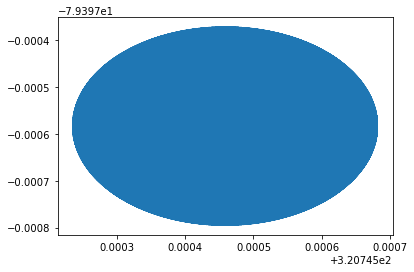

In [280]:
# Plot grid points 
plt.plot(xx[in_ellipse], yy[in_ellipse])

In [281]:
# Trying something else, doesn't seem to work
hgcoord = HG190611.coord
hg_ra = hgcoord.ra.value
hg_dec = hgcoord.dec.value

#for i in np.arange(np.shape(xx[in_ellipse])):
x_diff = (hg_ra - xx) * np.cos(hg_dec)
y_diff = hg_dec - yy    

ang_off = np.sqrt(x_diff**2 + y_diff**2)
ang_off*3600



array([[6.01790761, 6.01890554, 6.01990349, ..., 7.02131836, 7.02233209,
        7.02334583],
       [6.01740826, 6.01840628, 6.01940432, ..., 7.02089039, 7.02190417,
        7.02291798],
       [6.01690927, 6.01790737, 6.01890549, ..., 7.02046271, 7.02147657,
        7.02249043],
       ...,
       [5.70367617, 5.70472907, 5.70578198, ..., 6.75393378, 6.75498763,
        6.75604148],
       [5.70355569, 5.70460861, 5.70566154, ..., 6.75383203, 6.7548859 ,
        6.75593977],
       [5.70343561, 5.70448856, 5.70554151, ..., 6.75373062, 6.75478451,
        6.7558384 ]])

In [282]:
#Generate an analytical 2d gaussian
def gauss_2da(x,y, sma, smb):
    
    e_x = 1/(sma*np.sqrt(2*np.pi)) * np.exp(-(x-frb_ra)**2 / (2 * sma**2))
    e_y = 1/(smb*np.sqrt(2*np.pi)) * np.exp(-(y-frb_dec)**2 / (2 * smb**2))
    
    print(np.shape(e_x))
    w = e_x * e_y
    return w

(1000, 1000)
1.0000000000000004


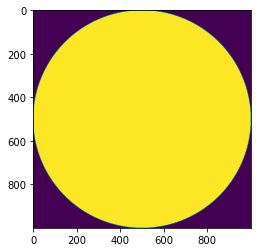

In [307]:
# Define weight scheme, using the grid points xx and yy and the sigma RA and Dec (a and b) in degs
w = gauss_2da(xx, yy, (a/3600), (b/3600)
w[~in_ellipse] = 0

# Normalize w
norm_w = w / np.sum(w)
print(np.sum(norm_w)) 
plt.imshow(norm_w)

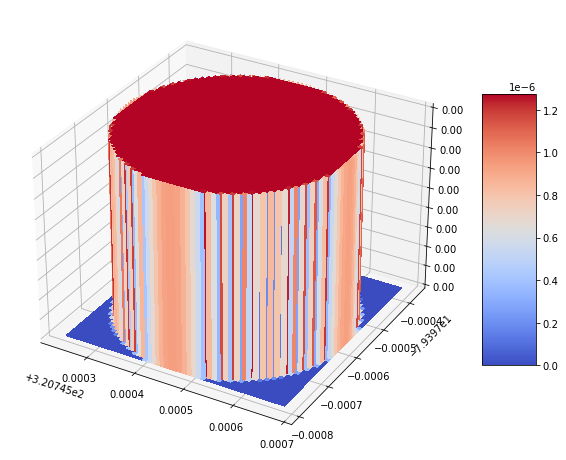

In [308]:
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xx, yy, norm_w, cmap=cm.coolwarm, linewidth=0, antialiased=False)

#ax.set_zlim(-5e-6, 5e-6)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [309]:
# Calculate average offset (should be close to 2.1'')
mean = np.sum(norm_w * ang_diff) #/ np.sum(norm_w) 
mean_ang = mean.to('arcsec').value
print(mean_ang)

2.1488147608635653


In [310]:
# Calculate SD from that (error on offset assuming sqrt(sigma_RA^2 + sigma_Dec^2) = 1.1, which seems more sensible for 190611)
sd = np.sqrt(np.sum((ang_diff-mean)**2 * norm_w))
print(sd.to('arcsec').value)

0.222103058641103
